In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from os import path
from astropy.io import fits

from spectrum import AtomicLine, Spectrum, FitsSpectrum
from common import list_files, list_directories, DATA_FOLDER, tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sources
* Na I:  https://physics.nist.gov/PhysRefData/Handbook/Tables/sodiumtable3.htm
* K  I:  https://physics.nist.gov/PhysRefData/Handbook/Tables/potassiumtable3.htm
* Ca I:  https://physics.nist.gov/PhysRefData/Handbook/Tables/calciumtable3.htm
* Ca II: https://physics.nist.gov/PhysRefData/Handbook/Tables/calciumtable4.htm

In [3]:
NA_I_LINES = [
    AtomicLine('Na I', 5889.950),
    AtomicLine('Na I', 5895.924)
]

K_I_LINES = [
    AtomicLine('K I', 7664.8991),
    AtomicLine('K I', 7698.9645),
    AtomicLine('K I', 5801.75),
    AtomicLine('K I', 5812.15)
]

CA_I_LINES = [
    AtomicLine('Ca I', 6102.722),
    AtomicLine('Ca I', 6122.219)
]

CA_II_LINES = [
    # TODO
]


In [4]:
def load_target(target_dir: str) -> list[FitsSpectrum]:
    return [FitsSpectrum(datafile) for band_dir in list_directories(target_dir) for datafile in list_files(band_dir)]

hd170740_spectra = load_target('data/fits/HD170740')
hd170740_w564 = FitsSpectrum('data/fits/HD170740/RED_564/HD170740_w564_n9_20160612_U.fits')
hd170740_w860 = FitsSpectrum('data/fits/HD170740/RED_860/HD170740_w860_n12_20160613_L.fits')

Line 1 [Å],Line 2 [Å],Deviation [Å],Radial velocity [km/s]
5895.54,5889.58,0.014,-18.8288


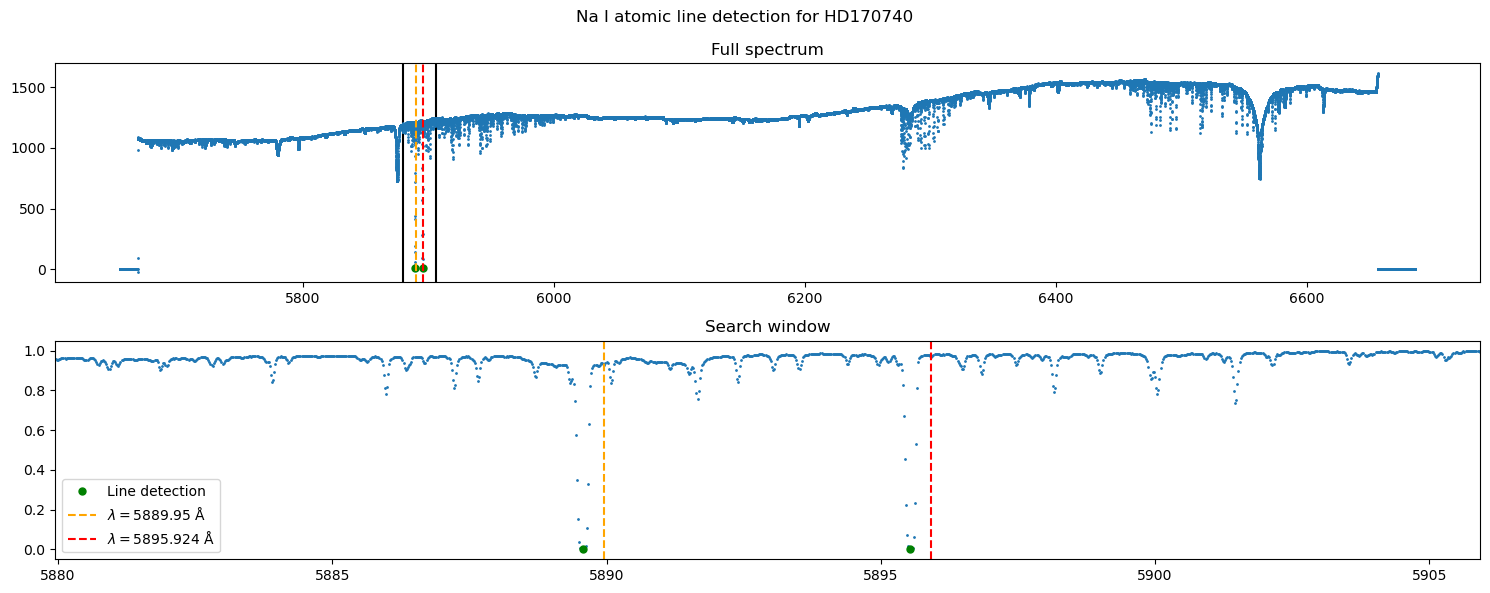

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
na_line_pairs = hd170740_w564.identify_atomic_line(
    NA_I_LINES[0], NA_I_LINES[1],
    axes=axes, draw_expected=True,
    output_difference=True,
    output_radial_velocity=True
)

fig.suptitle(f'Na I atomic line detection for {hd170740_w564.target}')
fig.tight_layout()

tabulate(na_line_pairs, ['Line 1 [Å]', 'Line 2 [Å]', 'Deviation [Å]', 'Radial velocity [km/s]'], tablefmt='html')

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
k_line_pairs = hd170740_w860.identify_atomic_line(
    K_I_LINES[0], K_I_LINES[1],
    axes=axes, draw_expected=True,
    output_difference=True,
    output_radial_velocity=True
)

fig.suptitle(f'K I atomic line detection for {hd170740_w860.target}')
fig.tight_layout()

tabulate(k_line_pairs, ['Line 1 [Å]', 'Line 2 [Å]', 'Deviation [Å]', 'Radial velocity [km/s]'], tablefmt='html')

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
ca_line_pairs = hd170740_w564.identify_atomic_line(
    CA_I_LINES[0], CA_I_LINES[1],
    axes=axes, draw_expected=True,
    output_difference=True,
    output_radial_velocity=True
)

fig.suptitle(f'Ca I atomic line detection for {hd170740_w564.target}')
fig.tight_layout()

tabulate(ca_line_pairs, ['Line 1 [Å]', 'Line 2 [Å]', 'Deviation [Å]', 'Radial velocity [km/s]'], tablefmt='html')

In [ ]:
def create_line_pair_table_rows(spectrum: Spectrum, line1: AtomicLine, line2: AtomicLine):
    line_pairs = spectrum.identify_atomic_line(line1, line2, output_difference=True, output_radial_velocity=True, tollerance=None)

    if line_pairs is None:
        return None
    else:
        extra_info = [spectrum.target, spectrum.format_obs_date()]
        return np.column_stack((np.full((line_pairs.shape[0], len(extra_info)), extra_info), line_pairs))

In [ ]:
na_line_pairs_all = np.concatenate([
    rows for spectrum in tqdm(hd170740_spectra, 'Searching Na I lines')
        if (rows := create_line_pair_table_rows(spectrum, NA_I_LINES[0], NA_I_LINES[1])) is not None
])

headers = ['Target', 'Observation Date', 'Line 1 [Å]', 'Line 2 [Å]', 'Deviation [Å]', 'Radial velocity [km/s]']
tabulate(na_line_pairs_all, headers, tablefmt='html')

In [ ]:
k_line_pairs_all = np.concatenate([create_line_pair_table_rows(spectrum, K_I_LINES[2], K_I_LINES[3]) for spectrum in tqdm(hd170740_spectra, 'Searching K I lines')])

headers = ['Target', 'Line 1 [Å]', 'Line 2 [Å]', 'Deviation [Å]', 'Radial velocity [km/s]']
tabulate(k_line_pairs_all, headers, tablefmt='html')

In [ ]:
ca_line_pairs_all = np.concatenate([create_line_pair_table_rows(spectrum, CA_I_LINES[0], CA_I_LINES[1]) for spectrum in tqdm(hd170740_spectra, 'Searching Ca I lines')])

headers = ['Target', 'Line 1 [Å]', 'Line 2 [Å]', 'Deviation [Å]', 'Radial velocity [km/s]']
tabulate(ca_line_pairs_all, headers, tablefmt='html')